In [1]:
## Step 1: Mount Google Drive (for accessing dataset and saving the model)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Step 2: Import Necessary Libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
## Step 3: Set Dataset Path from Google Drive
dataset_path = '/content/drive/MyDrive/Diseas'

In [4]:
## Step 4: Data Preprocessing
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Pixel values ko 0-1 range me normalize kiya
    rotation_range=20,          # Image rotate karne ka range 20 degrees
    width_shift_range=0.2,      # Image horizontal shift
    height_shift_range=0.2,     # Image vertical shift
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Zoom transformation
    horizontal_flip=True,       # Random horizontal flip
    validation_split=0.2        # 80% training, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
     color_mode='rgb',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
     color_mode='rgb',
    subset='validation'
)

Found 4305 images belonging to 4 classes.
Found 1075 images belonging to 4 classes.


In [5]:
# Model with Dropout and L2 Regularization
def create_cnn_model(input_shape=(150, 150, 3), num_classes=len(train_generator.class_indices)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        Flatten(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
# Initialize model
model = create_cnn_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 147968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      18,940,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,033,796 (72.61 MB)

 Trainable params: 19,033,796 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
# Train model
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping])

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.8943 - loss: 0.4659 - val_accuracy: 0.8791 - val_loss: 0.4975
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 366ms/step - accuracy: 0.8933 - loss: 0.4635 - val_accuracy: 0.9098 - val_loss: 0.4163
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8973 - loss: 0.4416 - val_accuracy: 0.9219 - val_loss: 0.3862
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8954 - loss: 0.4711 - val_accuracy: 0.9191 - val_loss: 0.3925
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 353ms/step - accuracy: 0.9053 - loss: 0.4530 - val_accuracy: 0.9144 - val_loss: 0.4131
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 49s 360ms/step - accuracy: 0.9126 - loss: 0.4325 - val_accuracy: 0.9256 - val_loss: 0.3811
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 49s 360ms/step - accuracy: 0.9037 - loss: 0.4542 - val_accuracy: 0.9200 - val_loss: 0.3955
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.8991 - loss: 0

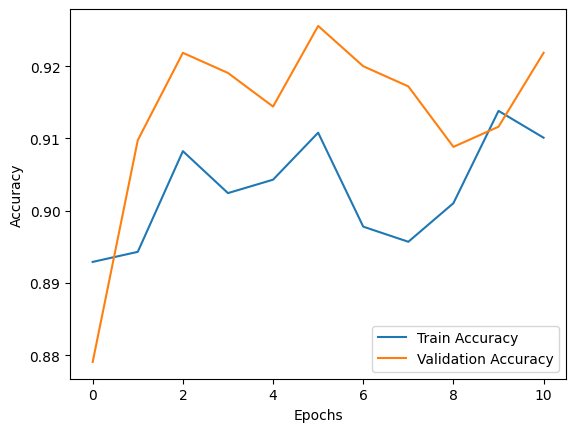

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

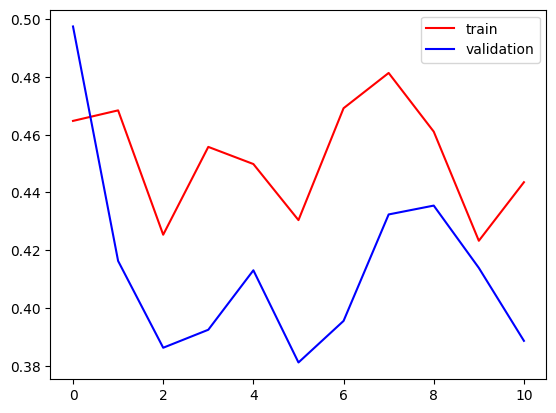

In [16]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [17]:
model.save("/content/drive/MyDrive/paddy_leaf_CNN_3(UPDATED)_disease_model.keras")

In [18]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/paddy_leaf_CNN_3(UPDATED)_disease_model.keras")

In [19]:
## Step 10: Make Predictions
import random
from tensorflow.keras.preprocessing import image

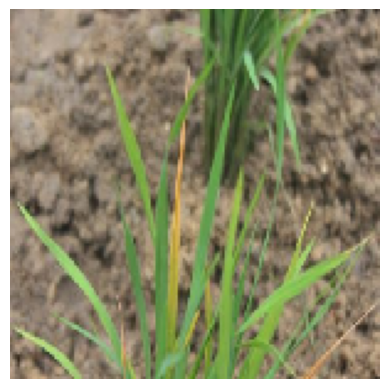

In [27]:
# Select a random image from validation set
random_image_path = random.choice(val_generator.filepaths)
img = image.load_img(random_image_path, target_size=image_size)
plt.imshow(img)
plt.axis('off')
plt.show()

In [28]:
# Preprocess the image
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

In [29]:
# Predict
y_pred = model.predict(img_array)
pred_class = np.argmax(y_pred)
print(f"Predicted Class: {list(train_generator.class_indices.keys())[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class: Tungro
